# Method 2 - Rest Ideas After 20

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 20].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

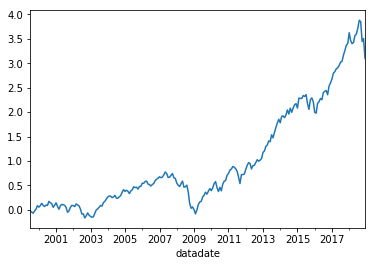

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.084198
2000-12-31    0.008523
2001-12-31   -0.003161
2002-12-31   -0.186505
2003-12-31    0.376529
2004-12-31    0.156709
2005-12-31    0.048244
2006-12-31    0.112923
2007-12-31   -0.002782
2008-12-31   -0.355140
2009-12-31    0.353993
2010-12-31    0.190224
2011-12-31    0.014403
2012-12-31    0.183294
2013-12-31    0.392621
2014-12-31    0.112165
2015-12-31    0.012823
2016-12-31    0.119539
2017-12-31    0.223970
2018-12-31   -0.069501
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2308.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.03e-183
Time:                        01:06:25   Log-Likelihood:                 844.27
No. Observations:                 234   AIC:                            -1679.
Df Residuals:                     229   BIC:                            -1661.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.913      0.000       0.001       0.003
mktrf          0.9435      0.012     76.300      0.000       0.919       0.968
me             0.1447      0.014     10.058      0.000       0.116       0.173
ia             0.1481      0.022      6.773      0.000       0.105       0.191
roe            0.0258      0.019      1.379      0.169      -0.011       0.063
==============================================================================
Omnibus:                       18.323   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.721
Skew:                           0.110   Prob(JB):                     1.08e-13
Kurtosis:                       5.465   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1230.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.73e-153
Time:                        01:06:25   Log-Likelihood:                 844.27
No. Observations:                 234   AIC:                            -1679.
Df Residuals:                     229   BIC:                            -1661.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      3.690      0.000       0.001       0.003
mktrf          0.9435      0.017     54.958      0.000       0.910       0.977
me             0.1447      0.042      3.416      0.001       0.062       0.228
ia             0.1481      0.046      3.242      0.001       0.059       0.238
roe            0.0258      0.020      1.260      0.208      -0.014       0.066
==============================================================================
Omnibus:                       18.323   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.721
Skew:                           0.110   Prob(JB):                     1.08e-13
Kurtosis:                       5.465   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1319.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.31e-157
Time:                        01:06:25   Log-Likelihood:                 844.27
No. Observations:                 234   AIC:                            -1679.
Df Residuals:                     229   BIC:                            -1661.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      3.655      0.000       0.001       0.003
mktrf          0.9435      0.017     56.571      0.000       0.911       0.976
me             0.1447      0.042      3.480      0.001       0.063       0.226
ia             0.1481      0.053      2.785      0.005       0.044       0.252
roe            0.0258      0.021      1.225      0.221      -0.015       0.067
==============================================================================
Omnibus:                       18.323   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.721
Skew:                           0.110   Prob(JB):                     1.08e-13
Kurtosis:                       5.465   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2169.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.10e-190
Time:                        01:06:25   Log-Likelihood:                 863.21
No. Observations:                 234   AIC:                            -1714.
Df Residuals:                     228   BIC:                            -1694.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      4.258      0.000       0.001       0.003
mktrf          0.9572      0.011     83.583      0.000       0.935       0.980
smb            0.1763      0.015     11.668      0.000       0.147       0.206
hml            0.0468      0.018      2.625      0.009       0.012       0.082
rmw            0.0746      0.020      3.704      0.000       0.035       0.114
cma            0.0717      0.026      2.802      0.006       0.021       0.122
==============================================================================
Omnibus:                       52.409   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.058
Skew:                           0.730   Prob(JB):                     2.53e-61
Kurtosis:                       8.147   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1535.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.47e-173
Time:                        01:06:25   Log-Likelihood:                 863.21
No. Observations:                 234   AIC:                            -1714.
Df Residuals:                     228   BIC:                            -1694.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      3.985      0.000       0.001       0.003
mktrf          0.9572      0.012     81.611      0.000       0.934       0.980
smb            0.1763      0.031      5.715      0.000       0.116       0.237
hml            0.0468      0.040      1.159      0.246      -0.032       0.126
rmw            0.0746      0.019      3.913      0.000       0.037       0.112
cma            0.0717      0.030      2.388      0.017       0.013       0.131
==============================================================================
Omnibus:                       52.409   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.058
Skew:                           0.730   Prob(JB):                     2.53e-61
Kurtosis:                       8.147   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2068.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.06e-187
Time:                        01:06:25   Log-Likelihood:                 863.21
No. Observations:                 234   AIC:                            -1714.
Df Residuals:                     228   BIC:                            -1694.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      3.994      0.000       0.001       0.003
mktrf          0.9572      0.011     90.198      0.000       0.936       0.978
smb            0.1763      0.030      5.911      0.000       0.118       0.235
hml            0.0468      0.043      1.094      0.274      -0.037       0.131
rmw            0.0746      0.020      3.683      0.000       0.035       0.114
cma            0.0717      0.031      2.323      0.020       0.011       0.132
==============================================================================
Omnibus:                       52.409   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.058
Skew:                           0.730   Prob(JB):                     2.53e-61
Kurtosis:                       8.147   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2319.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.95e-184
Time:                        01:06:25   Log-Likelihood:                 844.83
No. Observations:                 234   AIC:                            -1680.
Df Residuals:                     229   BIC:                            -1662.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.000      5.651      0.000       0.002       0.003
mktrf          0.9249      0.011     81.433      0.000       0.903       0.947
smb            0.1427      0.014     10.063      0.000       0.115       0.171
hml            0.1271      0.014      9.028      0.000       0.099       0.155
umd           -0.0112      0.009     -1.212      0.227      -0.029       0.007
==============================================================================
Omnibus:                       45.488   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.019
Skew:                           0.701   Prob(JB):                     1.81e-40
Kurtosis:                       7.100   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     973.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.90e-142
Time:                        01:06:25   Log-Likelihood:                 844.83
No. Observations:                 234   AIC:                            -1680.
Df Residuals:                     229   BIC:                            -1662.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      3.916      0.000       0.001       0.004
mktrf          0.9249      0.018     50.921      0.000       0.889       0.961
smb            0.1427      0.033      4.313      0.000       0.078       0.208
hml            0.1271      0.047      2.685      0.007       0.034       0.220
umd           -0.0112      0.014     -0.786      0.432      -0.039       0.017
==============================================================================
Omnibus:                       45.488   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.019
Skew:                           0.701   Prob(JB):                     1.81e-40
Kurtosis:                       7.100   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1083.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.82e-147
Time:                        01:06:25   Log-Likelihood:                 844.83
No. Observations:                 234   AIC:                            -1680.
Df Residuals:                     229   BIC:                            -1662.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      3.668      0.000       0.001       0.004
mktrf          0.9249      0.018     51.409      0.000       0.890       0.960
smb            0.1427      0.034      4.204      0.000       0.076       0.209
hml            0.1271      0.055      2.328      0.020       0.020       0.234
umd           -0.0112      0.012     -0.926      0.354      -0.035       0.012
==============================================================================
Omnibus:                       45.488   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.019
Skew:                           0.701   Prob(JB):                     1.81e-40
Kurtosis:                       7.100   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1089.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.26e-90
Time:                        01:06:25   Log-Likelihood:                 419.99
No. Observations:                 120   AIC:                            -830.0
Df Residuals:                     115   BIC:                            -816.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      3.548      0.001       0.001       0.004
mktrf          0.9279      0.019     48.228      0.000       0.890       0.966
me             0.1188      0.019      6.252      0.000       0.081       0.156
ia             0.2193      0.030      7.369      0.000       0.160       0.278
roe           -0.0085      0.026     -0.324      0.746      -0.061       0.044
==============================================================================
Omnibus:                        6.995   Durbin-Watson:                   1.514
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                9.455
Skew:                           0.279   Prob(JB):                      0.00885
Kurtosis:                       4.257   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     887.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.00e-85
Time:                        01:06:25   Log-Likelihood:                 419.99
No. Observations:                 120   AIC:                            -830.0
Df Residuals:                     115   BIC:                            -816.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.311      0.021       0.000       0.005
mktrf          0.9279      0.024     39.362      0.000       0.882       0.974
me             0.1188      0.046      2.590      0.010       0.029       0.209
ia             0.2193      0.039      5.673      0.000       0.144       0.295
roe           -0.0085      0.025     -0.345      0.730      -0.057       0.040
==============================================================================
Omnibus:                        6.995   Durbin-Watson:                   1.514
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                9.455
Skew:                           0.279   Prob(JB):                      0.00885
Kurtosis:                       4.257   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1550.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.43e-99
Time:                        01:06:25   Log-Likelihood:                 419.99
No. Observations:                 120   AIC:                            -830.0
Df Residuals:                     115   BIC:                            -816.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.118      0.034       0.000       0.005
mktrf          0.9279      0.021     45.238      0.000       0.888       0.968
me             0.1188      0.047      2.517      0.012       0.026       0.211
ia             0.2193      0.038      5.831      0.000       0.146       0.293
roe           -0.0085      0.023     -0.373      0.709      -0.053       0.036
==============================================================================
Omnibus:                        6.995   Durbin-Watson:                   1.514
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                9.455
Skew:                           0.279   Prob(JB):                      0.00885
Kurtosis:                       4.257   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     945.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.28e-91
Time:                        01:06:25   Log-Likelihood:                 425.27
No. Observations:                 120   AIC:                            -838.5
Df Residuals:                     114   BIC:                            -821.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      3.341      0.001       0.001       0.004
mktrf          0.9749      0.019     49.995      0.000       0.936       1.013
smb            0.1711      0.022      7.748      0.000       0.127       0.215
hml            0.0494      0.027      1.825      0.071      -0.004       0.103
rmw            0.0805      0.032      2.524      0.013       0.017       0.144
cma            0.1323      0.035      3.784      0.000       0.063       0.202
==============================================================================
Omnibus:                       42.712   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.598
Skew:                           1.115   Prob(JB):                     6.75e-42
Kurtosis:                       8.740   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1081.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.88e-94
Time:                        01:06:25   Log-Likelihood:                 425.27
No. Observations:                 120   AIC:                            -838.5
Df Residuals:                     114   BIC:                            -821.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.686      0.007       0.001       0.004
mktrf          0.9749      0.018     54.468      0.000       0.940       1.010
smb            0.1711      0.042      4.061      0.000       0.089       0.254
hml            0.0494      0.061      0.809      0.418      -0.070       0.169
rmw            0.0805      0.029      2.791      0.005       0.024       0.137
cma            0.1323      0.034      3.847      0.000       0.065       0.200
==============================================================================
Omnibus:                       42.712   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.598
Skew:                           1.115   Prob(JB):                     6.75e-42
Kurtosis:                       8.740   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1978.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.63e-109
Time:                        01:06:26   Log-Likelihood:                 425.27
No. Observations:                 120   AIC:                            -838.5
Df Residuals:                     114   BIC:                            -821.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.540      0.011       0.001       0.004
mktrf          0.9749      0.014     72.075      0.000       0.948       1.001
smb            0.1711      0.042      4.062      0.000       0.089       0.254
hml            0.0494      0.065      0.762      0.446      -0.078       0.176
rmw            0.0805      0.030      2.703      0.007       0.022       0.139
cma            0.1323      0.037      3.562      0.000       0.059       0.205
==============================================================================
Omnibus:                       42.712   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.598
Skew:                           1.115   Prob(JB):                     6.75e-42
Kurtosis:                       8.740   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     996.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.22e-88
Time:                        01:06:26   Log-Likelihood:                 414.81
No. Observations:                 120   AIC:                            -819.6
Df Residuals:                     115   BIC:                            -805.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      4.464      0.000       0.002       0.005
mktrf          0.9083      0.018     51.322      0.000       0.873       0.943
smb            0.1489      0.020      7.388      0.000       0.109       0.189
hml            0.1632      0.020      8.085      0.000       0.123       0.203
umd           -0.0256      0.012     -2.054      0.042      -0.050      -0.001
==============================================================================
Omnibus:                       27.573   Durbin-Watson:                   1.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.469
Skew:                           0.778   Prob(JB):                     1.24e-18
Kurtosis:                       6.751   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     698.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.17e-79
Time:                        01:06:26   Log-Likelihood:                 414.81
No. Observations:                 120   AIC:                            -819.6
Df Residuals:                     115   BIC:                            -805.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.412      0.001       0.001       0.005
mktrf          0.9083      0.027     33.457      0.000       0.855       0.961
smb            0.1489      0.036      4.098      0.000       0.078       0.220
hml            0.1632      0.057      2.839      0.005       0.051       0.276
umd           -0.0256      0.013     -1.918      0.055      -0.052       0.001
==============================================================================
Omnibus:                       27.573   Durbin-Watson:                   1.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.469
Skew:                           0.778   Prob(JB):                     1.24e-18
Kurtosis:                       6.751   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     993.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.87e-88
Time:                        01:06:26   Log-Likelihood:                 414.81
No. Observations:                 120   AIC:                            -819.6
Df Residuals:                     115   BIC:                            -805.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.178      0.001       0.001       0.005
mktrf          0.9083      0.023     39.948      0.000       0.864       0.953
smb            0.1489      0.039      3.828      0.000       0.073       0.225
hml            0.1632      0.062      2.626      0.009       0.041       0.285
umd           -0.0256      0.010     -2.469      0.014      -0.046      -0.005
==============================================================================
Omnibus:                       27.573   Durbin-Watson:                   1.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.469
Skew:                           0.778   Prob(JB):                     1.24e-18
Kurtosis:                       6.751   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2428.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.62e-105
Time:                        01:06:26   Log-Likelihood:                 468.62
No. Observations:                 114   AIC:                            -927.2
Df Residuals:                     109   BIC:                            -913.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.769      0.000       0.001       0.003
mktrf          0.9578      0.012     80.293      0.000       0.934       0.981
me             0.1998      0.018     10.846      0.000       0.163       0.236
ia            -0.0615      0.026     -2.407      0.018      -0.112      -0.011
roe            0.0140      0.022      0.625      0.533      -0.030       0.059
==============================================================================
Omnibus:                        1.428   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.490   Jarque-Bera (JB):                0.986
Skew:                          -0.202   Prob(JB):                        0.611
Kurtosis:                       3.212   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1933.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.40e-100
Time:                        01:06:26   Log-Likelihood:                 468.62
No. Observations:                 114   AIC:                            -927.2
Df Residuals:                     109   BIC:                            -913.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.426      0.000       0.001       0.003
mktrf          0.9578      0.012     79.387      0.000       0.934       0.981
me             0.1998      0.019     10.715      0.000       0.163       0.236
ia            -0.0615      0.033     -1.871      0.061      -0.126       0.003
roe            0.0140      0.023      0.623      0.533      -0.030       0.058
==============================================================================
Omnibus:                        1.428   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.490   Jarque-Bera (JB):                0.986
Skew:                          -0.202   Prob(JB):                        0.611
Kurtosis:                       3.212   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2809.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.24e-109
Time:                        01:06:26   Log-Likelihood:                 468.62
No. Observations:                 114   AIC:                            -927.2
Df Residuals:                     109   BIC:                            -913.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.310      0.000       0.001       0.003
mktrf          0.9578      0.010     93.386      0.000       0.938       0.978
me             0.1998      0.021      9.337      0.000       0.158       0.242
ia            -0.0615      0.039     -1.560      0.119      -0.139       0.016
roe            0.0140      0.019      0.721      0.471      -0.024       0.052
==============================================================================
Omnibus:                        1.428   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.490   Jarque-Bera (JB):                0.986
Skew:                          -0.202   Prob(JB):                        0.611
Kurtosis:                       3.212   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     4501.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.42e-123
Time:                        01:06:26   Log-Likelihood:                 516.69
No. Observations:                 114   AIC:                            -1021.
Df Residuals:                     108   BIC:                            -1005.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      4.747      0.000       0.001       0.002
mktrf          0.9554      0.007    127.445      0.000       0.941       0.970
smb            0.1659      0.012     13.631      0.000       0.142       0.190
hml            0.0034      0.016      0.218      0.828      -0.027       0.034
rmw           -0.0714      0.019     -3.756      0.000      -0.109      -0.034
cma           -0.0907      0.024     -3.761      0.000      -0.139      -0.043
==============================================================================
Omnibus:                        1.458   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.482   Jarque-Bera (JB):                1.406
Skew:                          -0.165   Prob(JB):                        0.495
Kurtosis:                       2.567   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     4229.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.08e-122
Time:                        01:06:26   Log-Likelihood:                 516.69
No. Observations:                 114   AIC:                            -1021.
Df Residuals:                     108   BIC:                            -1005.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      4.394      0.000       0.001       0.002
mktrf          0.9554      0.008    118.576      0.000       0.940       0.971
smb            0.1659      0.011     14.976      0.000       0.144       0.188
hml            0.0034      0.014      0.245      0.806      -0.024       0.030
rmw           -0.0714      0.015     -4.877      0.000      -0.100      -0.043
cma           -0.0907      0.028     -3.260      0.001      -0.145      -0.036
==============================================================================
Omnibus:                        1.458   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.482   Jarque-Bera (JB):                1.406
Skew:                          -0.165   Prob(JB):                        0.495
Kurtosis:                       2.567   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     5493.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.21e-128
Time:                        01:06:26   Log-Likelihood:                 516.69
No. Observations:                 114   AIC:                            -1021.
Df Residuals:                     108   BIC:                            -1005.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      4.303      0.000       0.001       0.002
mktrf          0.9554      0.007    134.127      0.000       0.941       0.969
smb            0.1659      0.011     15.330      0.000       0.145       0.187
hml            0.0034      0.012      0.290      0.772      -0.020       0.026
rmw           -0.0714      0.012     -6.012      0.000      -0.095      -0.048
cma           -0.0907      0.031     -2.973      0.003      -0.151      -0.031
==============================================================================
Omnibus:                        1.458   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.482   Jarque-Bera (JB):                1.406
Skew:                          -0.165   Prob(JB):                        0.495
Kurtosis:                       2.567   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     4383.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.21e-119
Time:                        01:06:26   Log-Likelihood:                 502.01
No. Observations:                 114   AIC:                            -994.0
Df Residuals:                     109   BIC:                            -980.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      3.117      0.002       0.000       0.002
mktrf          0.9656      0.008    114.484      0.000       0.949       0.982
smb            0.1815      0.013     13.803      0.000       0.155       0.208
hml           -0.0045      0.014     -0.333      0.740      -0.031       0.022
umd            0.0109      0.010      1.070      0.287      -0.009       0.031
==============================================================================
Omnibus:                        7.436   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.029
Skew:                          -0.537   Prob(JB):                       0.0298
Kurtosis:                       3.571   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3110.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.54e-111
Time:                        01:06:26   Log-Likelihood:                 502.01
No. Observations:                 114   AIC:                            -994.0
Df Residuals:                     109   BIC:                            -980.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.680      0.007       0.000       0.002
mktrf          0.9656      0.009    103.910      0.000       0.947       0.984
smb            0.1815      0.013     13.677      0.000       0.156       0.208
hml           -0.0045      0.011     -0.419      0.675      -0.026       0.017
umd            0.0109      0.008      1.457      0.145      -0.004       0.026
==============================================================================
Omnibus:                        7.436   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.029
Skew:                          -0.537   Prob(JB):                       0.0298
Kurtosis:                       3.571   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3434.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.20e-113
Time:                        01:06:26   Log-Likelihood:                 502.01
No. Observations:                 114   AIC:                            -994.0
Df Residuals:                     109   BIC:                            -980.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.807      0.005       0.000       0.002
mktrf          0.9656      0.009    106.847      0.000       0.948       0.983
smb            0.1815      0.014     13.319      0.000       0.155       0.208
hml           -0.0045      0.010     -0.431      0.667      -0.025       0.016
umd            0.0109      0.007      1.522      0.128      -0.003       0.025
==============================================================================
Omnibus:                        7.436   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.029
Skew:                          -0.537   Prob(JB):                       0.0298
Kurtosis:                       3.571   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""